# MSIN0097: Predictive Analytics
________________________
# Individual Coursework: 
________________________

## Diabetic Retinopathy Detection  

### Word Count - 1998 (Excluding table of contents and appendix)

  
________________________



#### Link for GitHub Repository:

https://github.com/ankitmehani/MSIN0097_PredictiveAnalytics_2024.git


# Table of Contents:
_________________________________
* [1. Obtaining and Problem Definition](#Bullet1)
* [2. Exploratory Data Analysis (EDA)](#Bullet2)
   * [2.1. Examine the distribution of eye and severity](#Bullet2.1)
   * [2.2. Split Data into Training and Validation](#Bullet2.2)
   * [2.3. Balance the distribution in the training set](#Bullet2.3)
* [3. Data Preprocessing](#Bullet3)  
  * [3.1. Image Augmentation](#Bullet3.1)
  * [3.2. Training Set](#Bullet3.2)
* [4. Model Exploration and Selection](#Bullet4)  
* [5. Model Fine-Tuning and Integration](#Bullet5)  
  * [5.1. SQLite3](#Bullet5.1)
* [6. Evaluate the results](#Bullet6)  
* [7. Presentation of Final Solution](#Bullet7)  
  * [6.1. Word Cloud](#Bullet6.1)  
  * [6.2. Exporting the data as a parquet file](#Bullet6.2)  
* [8. Appendix](#Bullet8)

# 1. Obtaining and Problem Definition<a class="anchor" id="Bullet1"></a>

The objective is to automate Diabetic Retinopathy (DR) detection using color fundus photography, aiding early intervention and reducing healthcare burdens. Current solutions are manual, time-consuming, and resource-intensive. Framed as supervised offline learning, performance will be measured using accuracy, sensitivity, specificity, and AUC-ROC. 



Success hinges on high model accuracy and sensitivity to prompt early intervention, with comparable tasks in image classification and medical diagnosis. Human expertise is available for data labeling and validation. Assumptions include accurate data labeling and generalizability to diverse populations.These assumptions will be verified through expert review and external dataset validation.

The dataset comprises high-resolution retina images captured under various imaging conditions, with each subject having both left and right fields. Images are labeled with subject IDs and side indicators (e.g., "1_left.jpeg" denotes the left eye of patient ID 1). Clinicians rated the presence of diabetic retinopathy on a scale of 0 to 4, with the distribution of labels as follows: {0: 25,810, 1: 2,443, 2: 5,292, 4: 708, 3: 873}. The task is to develop an automated analysis system to assign scores based on this scale. The dataset includes images from different models and cameras, potentially affecting visual appearance. Some images depict the retina anatomically, while others are inverted. Inverted images are identifiable by the position of the macula relative to the optic nerve or the presence of a notch. Noise may exist in both images and labels, necessitating the development of robust algorithms capable of functioning amid variation and noise.

A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:

0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR


[Emma Dugas, 2015]

In [1]:
import resource
memory_usage = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
print("Memory usage (in bytes):", memory_usage)

Memory usage (in bytes): 81068032


In [2]:
# Copy the weights and configurations for the pre-trained models
!mkdir ~/.keras
!mkdir ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* \
    ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json \
    ~/.keras/models/


mkdir: /Users/ankitmehani/.keras: File exists
mkdir: /Users/ankitmehani/.keras/models: File exists


zsh:1: no matches found: ../input/keras-pretrained-models/*notop*
cp: ../input/keras-pretrained-models/imagenet_class_index.json: No such file or directory


##### Import necessary packages for run 

In [3]:
!pip install scikit-image
!pip install tensorflow
!pip install --upgrade tensorflow
!pip install scikit-learn
!pip install keras --upgrade
!pip install tensorflow --upgrade



In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures

# io related
from skimage.io import imread
import os
from glob import glob
%matplotlib inline 
import os
from keras.utils  import to_categorical

import tensorflow as tf
from keras import backend as K
from keras.applications.inception_v3 import preprocess_input

/Users/ankitmehani/Downloads/Notebooks/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


##### Load trainLabels.csv into datafeame - retina_df 

In [5]:
base_image_dir = os.path.join(
    '/Users/ankitmehani/VisualStudio/diabetic-retinopathy-detection/'
    )
retina_df = pd.read_csv(
    os.path.join(base_image_dir,
                  'trainLabels.csv'))
retina_df.sample(3)

image  level
23682   29921_left      1
24037  30362_right      0
8949   11228_right      0

# 2. Exploratory Data Analysis (EDA)<a class="anchor" id="Bullet2"></a>

Below code segment prepares a DataFrame containing retinal image data for further analysis.
retina_df containing additional columns - 
PatientId, 
path - where image is saved, 
exists , 
eye - 1 represent left and 0 is right image 
and 
level_cat.

In [6]:

#This line extracts the patient ID from the 'image' column by 
#splitting the filename at underscores and selecting the first part. 

#It adds this information as a new column named 
#'PatientId' to the DataFrame.
retina_df['PatientId'] = retina_df['image'].map(
    lambda x: x.split('_')[0])

#This line constructs the file paths for the images by 
#appending the image filenames to the base directory path. 
#It creates a new column named 'path' in the 
#DataFrame to store these paths.
retina_df['path'] = retina_df['image'].map(
    lambda x: os.path.join(
        base_image_dir, 'train' ,'{}.jpeg'.format(x)))

# Check if the image files exist at the specified paths
retina_df['exists'] = retina_df['path'].map(os.path.exists)

#This line checks if the image files exist at the paths 
#specified in the 'path' column. 
#It creates a new boolean column named 'exists'in the DataFrame 
#to indicate whether each image file exists.
print(retina_df['exists'].sum(),
       'images found of', retina_df.shape[0], 'total')

#1 indicates the left eye and 0 indicates the right eye.
retina_df['eye'] = retina_df['image'].map(
    lambda x: 1 if x.split('_')[-1]=='left' else 0)



#This line encodes the 'level' column using one-hot encoding. 
#It creates a new column named 'level_cat' in the 
#DataFrame to store the encoded labels.
retina_df['level_cat'] = retina_df['level'].map(
    lambda x: to_categorical(x, 1+retina_df['level'].max()))

#This line removes any rows with missing values (NaNs) 
#from the DataFrame.
retina_df.dropna(inplace = True)

#This line filters the DataFrame to include only the rows 
#where the image files exist.
retina_df = retina_df[retina_df['exists']]

#This line selects a random sample of 3 rows 
#from the DataFrame for display.
retina_df.sample(3)


35126 images found of 35126 total


image  level PatientId  \
17056   21424_left      0     21424   
31565  39855_right      0     39855   
2673    3334_right      2      3334   

                                                    path  exists  eye  \
17056  /Users/ankitmehani/VisualStudio/diabetic-retin...    True    1   
31565  /Users/ankitmehani/VisualStudio/diabetic-retin...    True    0   
2673   /Users/ankitmehani/VisualStudio/diabetic-retin...    True    0   

                       level_cat  
17056  [1.0, 0.0, 0.0, 0.0, 0.0]  
31565  [1.0, 0.0, 0.0, 0.0, 0.0]  
2673   [0.0, 0.0, 1.0, 0.0, 0.0]

In [7]:
retina_df.dtypes

image        object
level         int64
PatientId    object
path         object
exists         bool
eye           int64
level_cat    object
dtype: object

In [8]:
retina_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35126 entries, 0 to 35125
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      35126 non-null  object
 1   level      35126 non-null  int64 
 2   PatientId  35126 non-null  object
 3   path       35126 non-null  object
 4   exists     35126 non-null  bool  
 5   eye        35126 non-null  int64 
 6   level_cat  35126 non-null  object
dtypes: bool(1), int64(2), object(4)
memory usage: 1.6+ MB



### 2.1. Examine the distribution of eye and severity  <a class="anchor" id="Bullet2.1"></a>

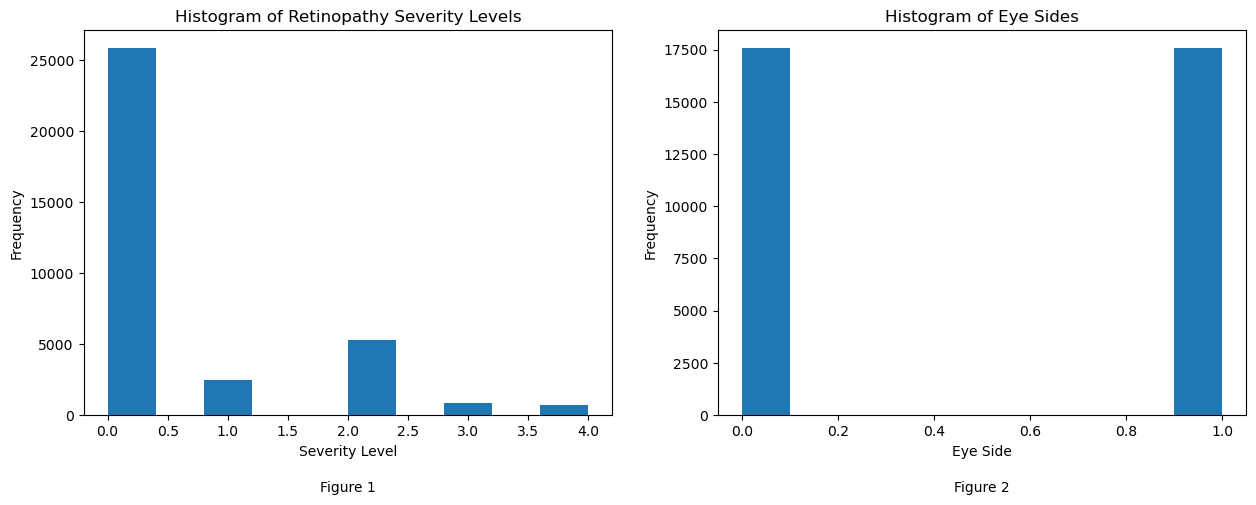

In [9]:
# Create subplots for two histograms
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Figure 1: Histogram of Retinopathy Severity Levels
axs[0].hist(retina_df['level'])
axs[0].set_title('Histogram of Retinopathy Severity Levels')
axs[0].set_xlabel('Severity Level')
axs[0].set_ylabel('Frequency')
axs[0].text(0.5, -0.2, 'Figure 1', ha='center', 
            transform=axs[0].transAxes)

# Figure 2: Histogram of Eye Sides
axs[1].hist(retina_df['eye'])
axs[1].set_title('Histogram of Eye Sides')
axs[1].set_xlabel('Eye Side')
axs[1].set_ylabel('Frequency')
axs[1].text(0.5, -0.2, 'Figure 2', ha='center', 
            transform=axs[1].transAxes)

plt.show()


### 2.2. Split Data into Training and Validation  <a class="anchor" id="Bullet2.2"></a>

This code splits a dataset of retinal images into training and validation sets, ensuring an equal distribution of unique patient IDs and their associated severity levels in both sets. 
It then prints out the number of samples in each set for verification.

In [10]:
from sklearn.model_selection import train_test_split

rr_df = retina_df[['PatientId', 'level']].drop_duplicates()

train_ids, valid_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = rr_df['level'])

raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]

valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]

print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 27176 validation 9632


### 2.3. Balance the distribution in the training set  <a class="anchor" id="Bullet2.3"></a>

Below code creates a new training dataset by sampling 75 observations from each group defined by the combination of retinopathy severity levels and eye sides, ensuring replacement. 
Afterward, it displays the sizes of both the new and original datasets for comparison. 
Finally, it generates histograms for the retinopathy severity levels and eye sides in the new training dataset.

/var/folders/b3/yr8wdb0s1tb6dxjftfb5bxrr0000gn/T/ipykernel_1033/2897002001.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = raw_train_df.groupby(['level', 'eye']).apply(


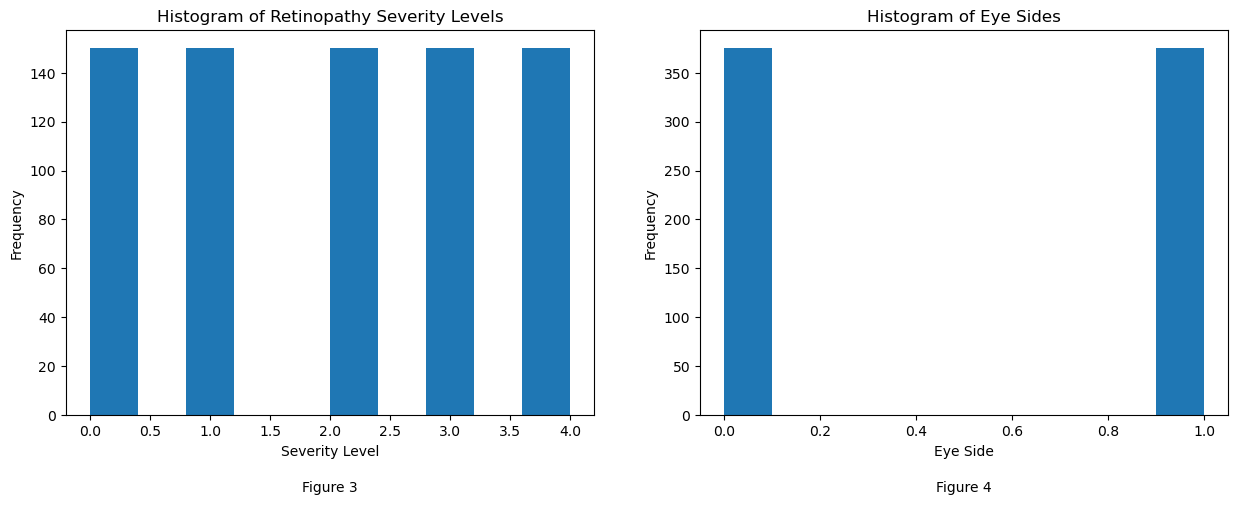

In [11]:

# Grouping and sampling
train_df = raw_train_df.groupby(['level', 'eye']).apply(
    lambda x: x.sample(75, replace=True)).reset_index(drop=True)

# Create subplots for two histograms
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Figure 3: Histogram of Retinopathy Severity Levels
axs[0].hist(train_df['level'])
axs[0].set_title('Histogram of Retinopathy Severity Levels')
axs[0].set_xlabel('Severity Level')
axs[0].set_ylabel('Frequency')
axs[0].text(0.5, -0.2, 'Figure 3', ha='center', 
            transform=axs[0].transAxes)

# Figure 4: Histogram of Eye Sides
axs[1].hist(train_df['eye'])
axs[1].set_title('Histogram of Eye Sides')
axs[1].set_xlabel('Eye Side')
axs[1].set_ylabel('Frequency')
axs[1].text(0.5, -0.2, 'Figure 4', ha='center', 
            transform=axs[1].transAxes)

plt.show()



In [12]:
level_counts = valid_df['level'].value_counts()
print(level_counts)


level
0    6759
2    1575
1     833
3     262
4     203
Name: count, dtype: int64


# 3. Data Preprocessing<a class="anchor" id="Bullet3"></a>

### 3.1. Image Augmentation  <a class="anchor" id="Bullet3.1"></a>

Below code defines two TensorFlow functions for image augmentation. 
Here's a breakdown:

tf_image_loader: 
This function loads images from file paths and performs various image augmentations like flipping, brightness adjustment, saturation adjustment, hue adjustment, and contrast adjustment. It returns a function _func which applies these augmentations to input images.

tf_augmentor: 
This function further augments images using transformations such as rotation, cropping, and resizing. It creates a batch processing pipeline _create_pipeline that applies the augmentations defined in tf_image_loader to the input dataset. The augmentation parameters such as rotation range, crop probability, and intermediate transformation type are configurable.

Overall, these functions allow for efficient image augmentation pipelines in TensorFlow for tasks like deep learning model training.

In [13]:

IMG_SIZE = (512, 512) # slightly smaller than vgg16 normally expects
def tf_image_loader(out_size, 
                      horizontal_flip = True, 
                      vertical_flip = False, 
                     random_brightness = True,
                     random_contrast = True,
                    random_saturation = True,
                    random_hue = True,
                      color_mode = 'rgb',
                       preproc_func = preprocess_input,
                       on_batch = False):
    def _func(X):
        with tf.name_scope('image_augmentation'):
            with tf.name_scope('input'):
                
                X = tf.image.decode_png(tf.io.read_file(X), 
                                        channels=3 
                                        if color_mode == 'rgb' 
                                        else 0)

                
                X = tf.image.resize_with_pad(X, 
                                             out_size[0], 
                                             out_size[1]) 
            with tf.name_scope('augmentation'):
                if horizontal_flip:
                    X = tf.image.random_flip_left_right(X)
                if vertical_flip:
                    X = tf.image.random_flip_up_down(X)
                if random_brightness:
                    X = tf.image.random_brightness(X, 
                    max_delta = 0.1)
                if random_saturation:
                    X = tf.image.random_saturation(X, 
                                                   lower = 0.75, 
                                                   upper = 1.5)
                if random_hue:
                    X = tf.image.random_hue(X, 
                                            max_delta = 0.15)
                if random_contrast:
                    X = tf.image.random_contrast(X, 
                                                 lower = 0.75, 
                                                 upper = 1.5)
                return preproc_func(X)
    if on_batch: 
        # we are meant to use it on a batch
        def _batch_func(X, y):
            return tf.map_fn(_func, X), y
        return _batch_func
    else:
        # we apply it to everything
        def _all_func(X, y):
            return _func(X), y         
        return _all_func
    
def tf_augmentor(out_size,
                intermediate_size = (640, 640),
                 intermediate_trans = 'crop',
                 batch_size = 16,
                   horizontal_flip = True, 
                  vertical_flip = False, 
                 random_brightness = True,
                 random_contrast = True,
                 random_saturation = True,
                    random_hue = True,
                  color_mode = 'rgb',
                   preproc_func = preprocess_input,
                   min_crop_percent = 0.001,
                   max_crop_percent = 0.005,
                   crop_probability = 0.5,
                   rotation_range = 10):
    
    load_ops = tf_image_loader(out_size = intermediate_size, 
                               horizontal_flip=horizontal_flip, 
                               vertical_flip=vertical_flip, 
                               random_brightness = random_brightness,
                               random_contrast = random_contrast,
                               random_saturation = random_saturation,
                               random_hue = random_hue,
                               color_mode = color_mode,
                               preproc_func = preproc_func,
                               on_batch=False)
    def batch_ops(X, y):
        batch_size = tf.shape(X)[0]
        with tf.name_scope('transformation'):
        #code borrowed from 
        #https://becominghuman.ai/data-augmentation-on-gpu-in-
        #tensorflow-13d14ecf2b19
        #The list of affine transformations that our image 
        #will go under. Every element is Nx8 tensor, 
        #where N is a batch size.
            transforms = []
            identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], 
                                   dtype=tf.float32)
            if rotation_range > 0:
                #angle_rad = rotation_range / 180 * np.pi
                
                #angles = 
                #tf.random.uniform(
                #[batch_size], -angle_rad, angle_rad)
                
                #transforms += 
                #[tf.raw_ops.ImageProjectiveTransformV2(
                #angles=angles, 
                #output_shape=[intermediate_size[0], 
                #intermediate_size[1]])]
                
                #transforms += 
                #[tf.contrib.image.angles_to_projective_transforms
                #(angles, 
                #intermediate_size[0], 
                #intermediate_size[1])]
                
                X = tf.image.rot90(X, tf.random.uniform([], 0, 4, 
                                                        dtype=tf.int32
                                                        ))

            if crop_probability > 0:
                #crop_pct = 
                
                #tf.random.uniform(
                #[batch_size], min_crop_percent, max_crop_percent)
                
                #left = tf.random.uniform(
                #[batch_size], 0, 
                #intermediate_size[0] * (1.0 - crop_pct))
                
                #top = tf.random.uniform(
                #[batch_size], 0, 
                #intermediate_size[1] * (1.0 - crop_pct))
                
                #crop_transform = tf.stack([
                #      crop_pct,
                #      tf.zeros([batch_size]), top,
                #     tf.zeros([batch_size]), crop_pct, left,
                #     tf.zeros([batch_size]),
                #      tf.zeros([batch_size])
                #  ], 1)
                
                #coin = tf.less(
                
                #tf.random.uniform(
                #[batch_size], 0, 1.0), crop_probability)
                
                #transforms += [
                #tf.where(coin, crop_transform, tf.tile(
                #tf.expand_dims(identity, 0), [batch_size, 1]))]
                
                X = tf.image.random_crop(X, size=[batch_size, 
                                                  out_size[0], 
                                                  out_size[1], 
                                                  3])
            if len(transforms)>0:
                X = tf.contrib.image.transform(X,
                      tf.contrib.image.compose_transforms(*transforms),
                      interpolation='BILINEAR') # or 'NEAREST'
            
            if intermediate_trans=='scale':
                 X = tf.image.resize_with_pad(X, out_size[0], 
                                              out_size[1])
            
            elif intermediate_trans=='crop':
                 X = tf.image.resize_with_crop_or_pad(X, 
                                                      out_size[0], 
                                                      out_size[1])
            
            else:
                raise ValueError(
                    'Invalid Operation {}'.format(intermediate_trans))
            return X, y
    def _create_pipeline(in_ds):
        batch_ds = in_ds.map(load_ops, 
                             num_parallel_calls=4).batch(batch_size)
        return batch_ds.map(batch_ops)
    return _create_pipeline


This function, named flow_from_dataframe, generates batches of augmented images and labels from a Pandas DataFrame. It uses TensorFlow Dataset operations to handle the data, shuffling if required. Augmentation is performed using a provided image data generator (idg). The function ensures thread safety during data generation.

In [14]:
def flow_from_dataframe(idg, 
                        in_df, 
                        path_col,
                        y_col, 
                        shuffle = True, 
                        color_mode = 'rgb'):
    files_ds = tf.data.Dataset.from_tensor_slices((
        in_df[path_col].values, 
        np.stack(in_df[y_col].values,0)))
    
    in_len = in_df[path_col].values.shape[0]
    
    while True:
        if shuffle:
            files_ds = files_ds.shuffle(in_len) 
            # shuffle the whole dataset
        
        
        next_batch = next(idg(files_ds).repeat().as_numpy_iterator())

        for i in range(max(in_len//32,1)):
            # NOTE: if we loop here it is 'thread-safe-ish' 
            #if we loop on the outside it is completely unsafe
            
            yield next_batch




This code initializes two image data generators, core_idg and valid_idg, for augmenting images during training and validation. The tf_augmentor function is used to create these generators with specified augmentation parameters such as flipping, brightness, contrast adjustments, and rotation.

These generators are then used to create TensorFlow data generators (train_gen and valid_gen) using the flow_from_dataframe function, which generates batches of augmented images and their corresponding labels from DataFrame paths. These generators are designed for training and validation data, respectively.

In [15]:
#trying to increase batchsize from 48 to 64 to faster training times.
batch_size = 48
core_idg = tf_augmentor(out_size = IMG_SIZE, 
                        color_mode = 'rgb', 
                        vertical_flip = True,
                        crop_probability=0.0, # crop doesn't work yet
                        batch_size = batch_size) 
valid_idg = tf_augmentor(out_size = IMG_SIZE, color_mode = 'rgb', 
                         crop_probability=0.0, 
                         horizontal_flip = False, 
                         vertical_flip = False, 
                         random_brightness = False,
                         random_contrast = False,
                         random_saturation = False,
                         random_hue = False,
                         rotation_range = 0,
                        batch_size = batch_size)

train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'level_cat')

valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') 
            # we can use much larger batches for evaluation

Below code snippet extracts a batch of validation data and labels from a generator. 

It then visualizes the images alongside their corresponding severity labels using matplotlib.
The images are displayed in a grid layout, with their severity levels indicated as titles.

This visualization aids in inspecting the validation data and understanding the model's performance.

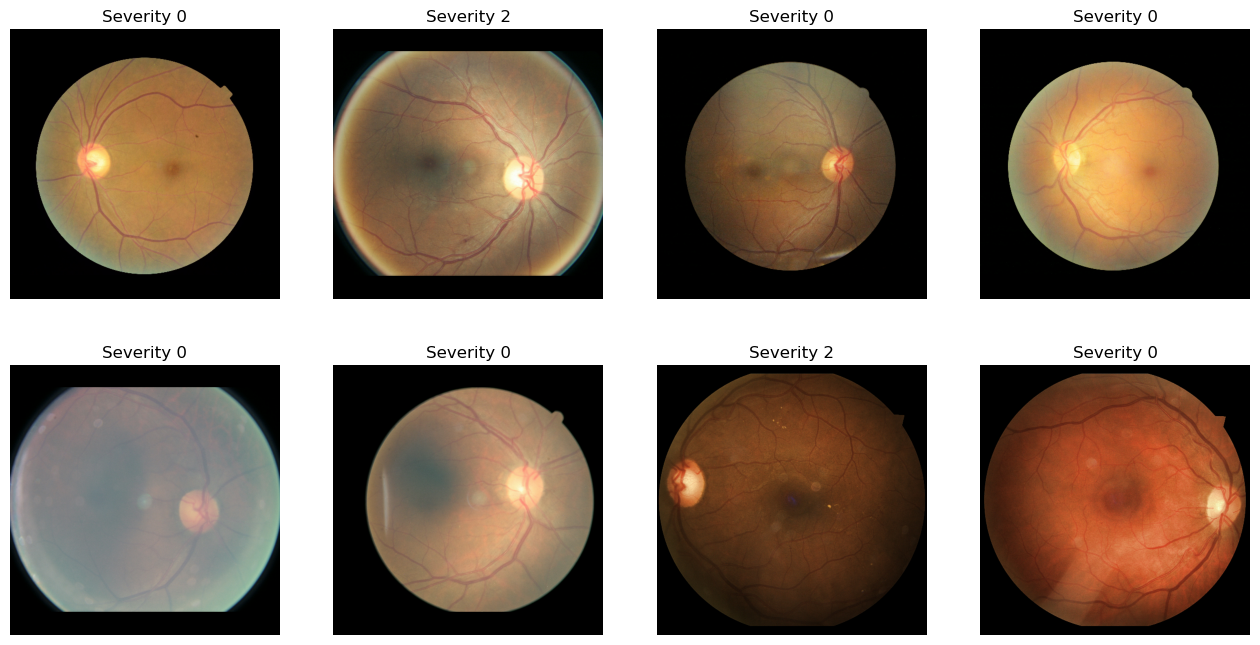

In [16]:
t_x, t_y = next(valid_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')
plt.show()

### 3.2. Training Set  <a class="anchor" id="Bullet3.2"></a>


This code segment retrieves a batch of training data (input) and corresponding severity labels using a generator. 

 It then employs matplotlib to generate a visualization (output) where the images are presented in a grid layout.


 Each image is accompanied by its severity level, represented as a title. 
 
 This visualization aids in inspecting the training data and understanding its characteristics.

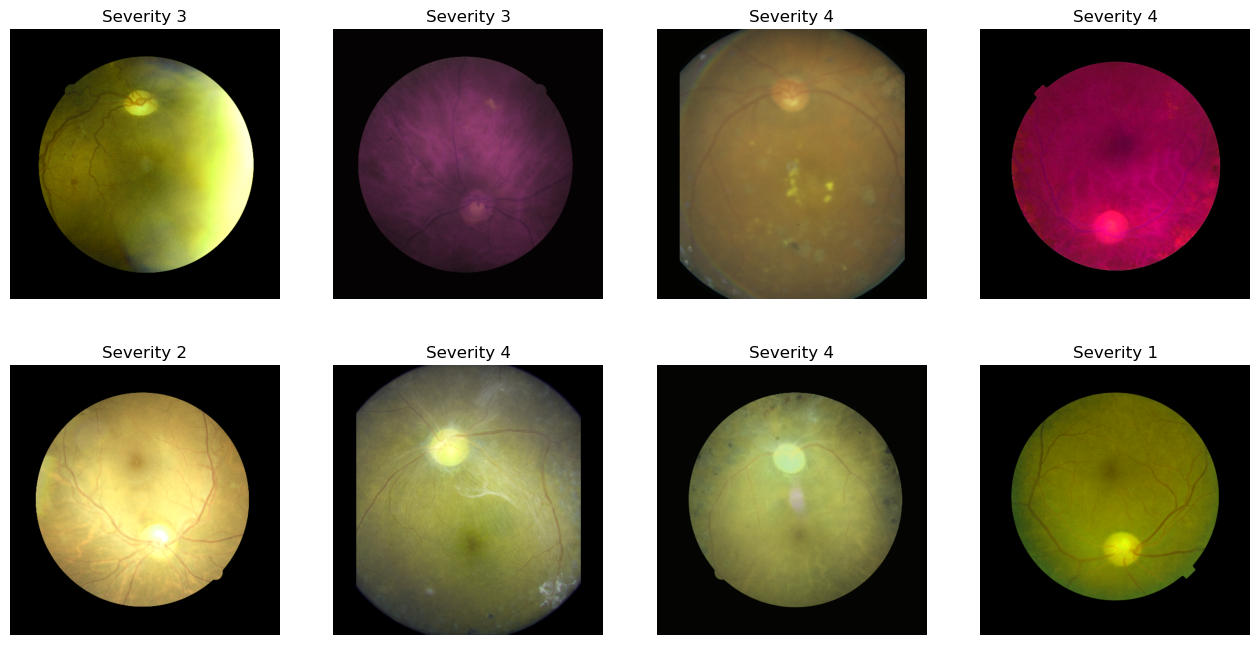

In [17]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')


# 4. Model Exploration and Selection<a class="anchor" id="Bullet4"></a>

This code segment constructs a CNN model with an attention mechanism for image classification tasks, leveraging pre-trained CNN architectures for feature extraction and incorporating regularization techniques for improved generalization

Here's a breakdown of what each line does:
1. Importing Dependencies
2. Input Layer
3. Base Pre-trained Model
4. Batch Normalization
5. Attention Mechanism
6. Global Average Pooling
7. Rescale Global Average Pooling
8. Dropout and Dense Layers
9. Output Layer
10. Model Compilation
11. Summary

In [18]:
import keras
print(keras.__version__)


3.2.1


### Attention Model

The basic idea is that a Global Average Pooling is too simplistic since some of the regions are more relevant than others. So we build an attention mechanism to turn pixels in the GAP on an off before the pooling and then rescale (Lambda layer) the results based on the number of pixels. The model could be seen as a sort of 'global weighted average' pooling. There is probably something published about it and it is very similar to the kind of attention models used in NLP. It is largely based on the insight that the winning solution annotated and trained a UNET model to segmenting the hand and transforming it. This seems very tedious if we could just learn attention.

In [19]:
# Importing Dependencies: Imports necessary modules 
#from Keras for building the model

from keras.applications.vgg16 import VGG16 as PTModel

from keras.applications.inception_resnet_v2 import (
    InceptionResNetV2 as PTModel)

from keras.applications.inception_v3 import InceptionV3 as PTModel

from keras.layers import (GlobalAveragePooling2D, Dense, Dropout, 
                          Flatten, Input, Conv2D, multiply, Lambda)

from keras.models import Model
from keras.layers import BatchNormalization
from keras.initializers import Constant
from keras.metrics import top_k_categorical_accuracy


#Input Layer: Defines an input layer with the shape of the 
#input data (t_x).

in_lay = Input(t_x.shape[1:])



#Base Pre-trained Model: 
#Initializes a pre-trained CNN model (VGG16, InceptionResNetV2, or 
#InceptionV3) without the top classification layers. 

#The model's weights are initialized with ImageNet weights.


base_pretrained_model = PTModel(input_shape=t_x.shape[1:], 
                                include_top=False, 
                                weights='imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.output_shape[-1]
pt_features = base_pretrained_model(in_lay)


#Batch Normalization: Adds batch normalization to the 
#extracted features from the pre-trained model.

bn_features = BatchNormalization()(pt_features)


#Attention Mechanism: Constructs an attention mechanism using 
#                     convolutional layers to focus on specific 
#                     regions of the image(attention mechanism
#                     to turn pixels in the GAP on an off)

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', 
                    activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', 
                    activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', 
                    activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))

up_c2 = Conv2D(pt_depth, kernel_size=(1, 1), padding='same', 
               activation='linear', use_bias=False, 
               kernel_initializer=Constant(up_c2_w))

up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])


# Global Average Pooling: Performs global average pooling on the 
#masked features and attention mask separately.
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)

#Rescale Global Average Pooling: Scales the global average pooled 
#features by the attention mask to handle missing values.
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, 
                                                        gap_mask])

#Dropout and Dense Layers: Applies dropout regularization and 
#dense layers for feature transformation.
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))

#Output Layer: Adds a dense output layer with softmax activation 
#for multi-class classification.
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)

#Model Compilation: Compiles the model with the Adam optimizer, 
#categorical cross-entropy loss function, and evaluation metrics.
retina_model = Model(inputs = [in_lay], outputs = [out_layer])

def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', 
                     loss = 'categorical_crossentropy',
                     metrics = ['categorical_accuracy', 
                                top_2_accuracy])

#retina_model.summary
retina_model.summary(line_length=60)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)    ┃ Output Shape ┃ Param # ┃ Connected to  ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer     │ (None, 512,  │       0 │ -             │
│ (InputLayer)    │ 512, 3)      │         │               │
├─────────────────┼──────────────┼─────────┼───────────────┤
│ inception_v3    │ (None, 14,   │ 21,802… │ input_layer[… │
│ (Functional)    │ 14, 2048)    │         │               │
├─────────────────┼──────────────┼─────────┼───────────────┤
│ batch_normaliz… │ (None, 14,   │   8,192 │ inception_v3… │
│ (BatchNormaliz… │ 14, 2048)    │         │               │
├─────────────────┼──────────────┼─────────┼───────────────┤
│ dropout         │ (None, 14,   │       0 │ batch_normal… │
│ (Dropout)       │ 14, 2048)    │         │               │
├─────────────────┼──────────────┼─────────┼───────────────┤
│ conv2d_94       │ (None, 14,   │ 131,136 │ dropout[0][0] │
│ (Conv2D)        │ 14, 64)      │         │               │
├─────────────────┼──────────────┼─────────┼───────────────┤
│ conv2d_95       │ (None, 14,   │   1,040 │ conv2d_94[0]… │
│ (Conv2D)        │ 14, 16)      │         │               │
├─────────────────┼──────────────┼─────────┼───────────────┤
│ conv2d_96       │ (None, 14,   │     136 │ conv2d_95[0]… │
│ (Conv2D)        │ 14, 8)       │         │               │
├─────────────────┼──────────────┼─────────┼───────────────┤
│ conv2d_97       │ (None, 14,   │       9 │ conv2d_96[0]… │
│ (Conv2D)        │ 14, 1)       │         │               │
├─────────────────┼──────────────┼─────────┼───────────────┤
│ conv2d_98       │ (None, 14,   │   2,048 │ conv2d_97[0]… │
│ (Conv2D)        │ 14, 2048)    │         │               │
├─────────────────┼──────────────┼─────────┼───────────────┤
│ multiply        │ (None, 14,   │       0 │ conv2d_98[0]… │
│ (Multiply)      │ 14, 2048)    │         │ batch_normal… │
├─────────────────┼──────────────┼─────────┼───────────────┤
│ global_average… │ (None, 2048) │       0 │ multiply[0][… │
│ (GlobalAverage… │              │         │               │
├─────────────────┼──────────────┼─────────┼───────────────┤
│ global_average… │ (None, 2048) │       0 │ conv2d_98[0]… │
│ (GlobalAverage… │              │         │               │
├─────────────────┼──────────────┼─────────┼───────────────┤
│ RescaleGAP      │ (None, 2048) │       0 │ global_avera… │
│ (Lambda)        │              │         │ global_avera… │
├─────────────────┼──────────────┼─────────┼───────────────┤
│ dropout_1       │ (None, 2048) │       0 │ RescaleGAP[0… │
│ (Dropout)       │              │         │               │
├─────────────────┼──────────────┼─────────┼───────────────┤
│ dense (Dense)   │ (None, 128)  │ 262,272 │ dropout_1[0]… │
├─────────────────┼──────────────┼─────────┼───────────────┤
│ dropout_2       │ (None, 128)  │       0 │ dense[0][0]   │
│ (Dropout)       │              │         │               │
├─────────────────┼──────────────┼─────────┼───────────────┤
│ dense_1 (Dense) │ (None, 5)    │     645 │ dropout_2[0]… │
└─────────────────┴──────────────┴─────────┴───────────────┘

 Total params: 22,208,262 (84.72 MB)

 Trainable params: 399,334 (1.52 MB)

 Non-trainable params: 21,808,928 (83.19 MB)

The above Layer Information table displays information about each layer in the neural network. It includes the following columns:

Layer (type): This column specifies the type of each layer in the network.
Output Shape: Indicates the shape of the output produced by each layer.
Param #: Represents the number of trainable parameters in each layer.
Connected to: Describes how each layer is connected to other layers in the network.


Each row in the table corresponds to a layer in the neural network, and the layers are arranged sequentially based on their order in the model architecture. Additionally, the model summary provides insights into the overall size of the model and the distribution of trainable and non-trainable parameters, which can be useful for understanding the complexity of the network and its memory requirements.


# 5. Model Fine-Tuning and Integration<a class="anchor" id="Bullet5"></a>

### 5.1. Model Control and Fitting  <a class="anchor" id="Bullet5.1"></a>

This code sets up callback functions in Keras for monitoring and controlling the training process of a neural network model:

1. ModelCheckpoint: Saves the best model weights based on validation loss to a specified file path.

2. ReduceLROnPlateau: Reduces the learning rate when the validation loss plateaus, aiming to improve training convergence.

3. EarlyStopping: Stops training if the validation loss doesn't improve after a specified number of epochs, preventing overfitting.

These callbacks are then compiled into a list (callbacks_list) and used during the model training phase to optimize model performance and prevent overfitting.

In [20]:
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler, 
                             EarlyStopping, ReduceLROnPlateau)

#weight_path - retina_weights.best.hdf5
weight_path="{}_weights.best.weights.h5".format('retina')


checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.8, patience=3, 
                                   verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, 
                                   min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6) 
                    # probably needs to be more patient
                    # keeping 6 due to system limits. 
callbacks_list = [checkpoint, early, reduceLROnPlat]

We are executing !rm -rf ~/.keras to clean up the .keras directory before starting training, which helps ensure a clean slate for the training process, preventing any potential conflicts or issues arising from previous configurations or cached files.

In [21]:
!rm -rf ~/.keras # clean up before starting training

This code trains the retina_model using the provided generators train_gen for training data and valid_gen for validation data. 
It specifies the number of steps per epoch and validation steps based on the batch size and the size of the respective datasets. 
Additionally, it sets the number of epochs to 5 and includes a list of callbacks for monitoring the training process, such as model checkpointing, early stopping, and reducing the learning rate on plateau.


In [22]:
model_fit_history = retina_model.fit(train_gen, 
                 steps_per_epoch=train_df.shape[0] // batch_size,
                 validation_data=valid_gen, 
                 validation_steps=valid_df.shape[0] // batch_size,
# 28/03/2024
    #Run 1 - Initially took epochs as 30 but fitting took too much 
    #        because of iterative/recursive runs and kernel aborted 
    #        during prediction.
    #        Hence updated epochs as 1 , later will try with more than 1.
    #Run2  - Modified epochs to 5.

#30/03/2024
    #Run1  - Modified epochs to 1.
    #Run2  - Modified epochs to 2.
    #Run3  - Modified epochs to 3.
    #Run4  - Modified epochs to 4.
    #Run5  - Modified epochs to 5.

#31/03/2024
    #Run  - Modified epochs to 6.

#01/04/2024
    #Run  - Modified epochs to 9.

#02/04/2024
    #Run  - Modified epochs to 15.

#15/04/2024
    #Run  - Modified epochs to 10.


                 epochs= 10 , 
                 callbacks=callbacks_list
                )



Epoch 1/10


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6379 - loss: 0.9453 - top_2_accuracy: 0.7573
Epoch 1: val_loss improved from inf to 1.43363, saving model to retina_weights.best.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 689s 49s/step - categorical_accuracy: 0.6509 - loss: 0.9169 - top_2_accuracy: 0.7667 - val_categorical_accuracy: 0.4375 - val_loss: 1.4336 - val_top_2_accuracy: 0.5625 - learning_rate: 0.0010
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.8760 - loss: 0.4811 - top_2_accuracy: 0.9245
Epoch 2: val_loss improved from 1.43363 to 0.99419, saving model to retina_weights.best.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 703s 50s/step - categorical_accuracy: 0.8659 - loss: 0.5118 - top_2_accuracy: 0.9193 - val_categorical_accuracy: 0.7083 - val_loss: 0.9942 - val_top_2_accuracy: 0.8333 - learning_rate: 0.0010
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9219 - loss: 0.2818 - top_2_accuracy: 0.9843
Epoch 3: val_loss d

Below section presents the model training history data (loss, accuracy, learning rate, etc.) in a neatly formatted table with consistent column widths and alignment for easy readability.

In [23]:
# Define column headers and column widths
column_headers = ["Epoch", " Cat_Acc", " Loss", "Top2Acc",
                  "Val_Acc", " ValLoss", " ValTop2Acc",
                  " LRate"]

# Adjust the column widths for better alignment and readability
column_widths = [5, 7, 7, 9, 7, 8, 8, 7]

# Print the header
header = "".join(f"{header:<{width}}" for header, width in 
                 zip(column_headers, column_widths))
print(header)
print("=" * len(header))

# Print each row of model training history
for epoch, metrics in enumerate(zip(
    *model_fit_history.history.values())):
    # Format and print each metric according to the 
    # specified widths and precision
    row = (
        f"{epoch:<{column_widths[0]}} "  # Epoch
        f"{metrics[0]:<{column_widths[1]:.2f}} "  
        # Categorical Accuracy
        
        f"{metrics[1]:<{column_widths[2]:.2f}} "  # Loss
        
        f"{metrics[2]:<{column_widths[3]:.2f}} "  # Top 2 Accuracy
        
        f"{metrics[3]:<{column_widths[4]:.2f}} "  
        # Val Categorical Accuracy
        
        f"{metrics[4]:<{column_widths[5]:.2f}} "  # Val Loss
        
        f"{metrics[5]:<{column_widths[6]:.2f}} "  
        # Val Top 2 Accuracy
        
        f"{metrics[6]:<{column_widths[7]:.2f}} "  # Learning Rate
    )
    # Print the row
    print(row)


Epoch Cat_Acc Loss  Top2Acc  Val_Acc ValLoss ValTop2Acc LRate 
0     0.8     0.5     0.9       0.4     1e+00    0.6      0.001   
1     0.7     1e+00   0.8       0.7     1e+00    0.8      0.001   
2     1e+00   0.2     1e+00     0.7     1e+00    0.8      0.001   
3     0.8     0.8     0.9       0.3     2e+00    0.5      0.001   
4     0.8     0.6     0.9       0.2     2e+00    0.4      0.001   
5     1e+00   0.2     1e+00     0.2     3e+00    0.4      0.0008  
6     0.8     0.7     0.9       0.4     2e+00    0.6      0.0008  
7     0.8     0.7     0.9       0.3     2e+00    0.6      0.0008  


In [24]:
# Load the best version of the model
retina_model.load_weights(weight_path)

In [25]:
# Save the model using the native Keras format
retina_model.save('full_retina_model_160424_V1.keras')


### 5.2. Attention Map generation  <a class="anchor" id="Bullet5.2"></a>

This code is populating test_X and test_Y arrays with the entire validation dataset, batch by batch, by iterating over the validation generator and tracking progress with a tqdm progress bar.

In [26]:
from tqdm.notebook import tqdm


#This creates a new generator valid_gen using the flow_from_dataframe 
#function, which generates batches of data from the 
#validation dataframe (valid_df). 
#This generator will yield batches of input data (c_x) and 
#corresponding target data (c_y).

# fresh valid gen
valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col='path',
                             y_col='level_cat') 

#calculates the number of batches (vbatch_count) based on the size 
#of the validation dataframe and the specified batch size.
vbatch_count = (valid_df.shape[0] // batch_size - 1)
out_size = vbatch_count * batch_size

#initialize NumPy arrays test_X and test_Y to store the input and 
#target data for validation.
test_X = np.zeros((out_size,) + t_x.shape[1:], dtype=np.float32)
test_Y = np.zeros((out_size,) + t_y.shape[1:], dtype=np.float32)

#Iterates over the batches of data yielded by valid_gen, with the 
#loop counter i and the corresponding data c_x and c_y.
for i, (c_x, c_y) in zip(tqdm(range(vbatch_count)), valid_gen):
    #Computes the starting index j for storing the current batch of 
    #data in the test_X and test_Y arrays.
    j = i * batch_size
    #assigns the current batch of input data c_x and target data c_y 
    #to the appropriate slices of the test_X and test_Y arrays.
    test_X[j:(j + c_x.shape[0])] = c_x
    test_Y[j:(j + c_x.shape[0])] = c_y


  0%|          | 0/199 [00:00<?, ?it/s]

## Show Attention
Did our attention model learn anything useful?

This code iterates over the layers of a neural network model (retina_model) starting from the second layer. For each layer, it performs the following steps:

1. Checks if the previous layer is an input layer. If so, it skips to the next layer.
2. Retrieves the output shape of the previous layer (prev_layer_output_shape).
3. Retrieves the current layer.
4. Checks if the output shape of the previous layer has 4 dimensions (indicating a convolutional layer). 
If it does and the last dimension is 1, it prints information about the previous layer's output shape and the current layer, and then breaks out of the loop.

In summary, this code is finding the first convolutional layer in the model that has an output shape with 4 dimensions and a depth of 1, and it prints information about that layer.

In [27]:

# Iterate over layers starting from the second layer
for i in range(1, len(retina_model.layers)):
    if isinstance(retina_model.layers[i - 1], 
                  tf.keras.layers.InputLayer):
        continue
    prev_layer_output_shape = retina_model.layers[i - 1].output.shape
    current_layer = retina_model.layers[i]
    if len(prev_layer_output_shape) == 4:
        if prev_layer_output_shape[-1]==1:
            print("Previous layer output shape:", 
                  prev_layer_output_shape)
            print("Current layer:", current_layer)
            break


Previous layer output shape: (None, 14, 14, 1)
Current layer: <Conv2D name=conv2d_98, built=True>


In [28]:
attn_layer

<KerasTensor shape=(None, 14, 14, 2048), dtype=float32, sparse=False, name=keras_tensor_319>

this code snippet helps identify the attention layer within the model based on its output shape, specifically looking for layers with a shape of (None, None, None, 1)

In [29]:
# Iterate through the layers of the model and print their 
#names and indices
for i, layer in enumerate(retina_model.layers):
    print(f"Layer {i}: {layer.name}")

# Identify the attention layer by its name and 
#retrieve its index
attn_layer_name = "conv2d_98"  
attn_layer_index = None
for i, layer in enumerate(retina_model.layers):
    if layer.name == attn_layer_name:
        attn_layer_index = i
        break

if attn_layer_index is not None:
    print(
        f"The index of the attention layer '{attn_layer_name}' is: "
        f"{attn_layer_index}"
        )
else:
    print(
        f"Attention layer '{attn_layer_name}' not found in the model.")


Layer 0: input_layer
Layer 1: inception_v3
Layer 2: batch_normalization_94
Layer 3: dropout
Layer 4: conv2d_94
Layer 5: conv2d_95
Layer 6: conv2d_96
Layer 7: conv2d_97
Layer 8: conv2d_98
Layer 9: multiply
Layer 10: global_average_pooling2d
Layer 11: global_average_pooling2d_1
Layer 12: RescaleGAP
Layer 13: dropout_1
Layer 14: dense
Layer 15: dropout_2
Layer 16: dense_1
The index of the attention layer 'conv2d_98' is: 8


This code generates and visualizes attention maps for a set of randomly selected images from the test dataset.

This code is performing the following tasks:
1. Random Index Selection
2. Model Setup
3. Function Definition (attn_func)
4. Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


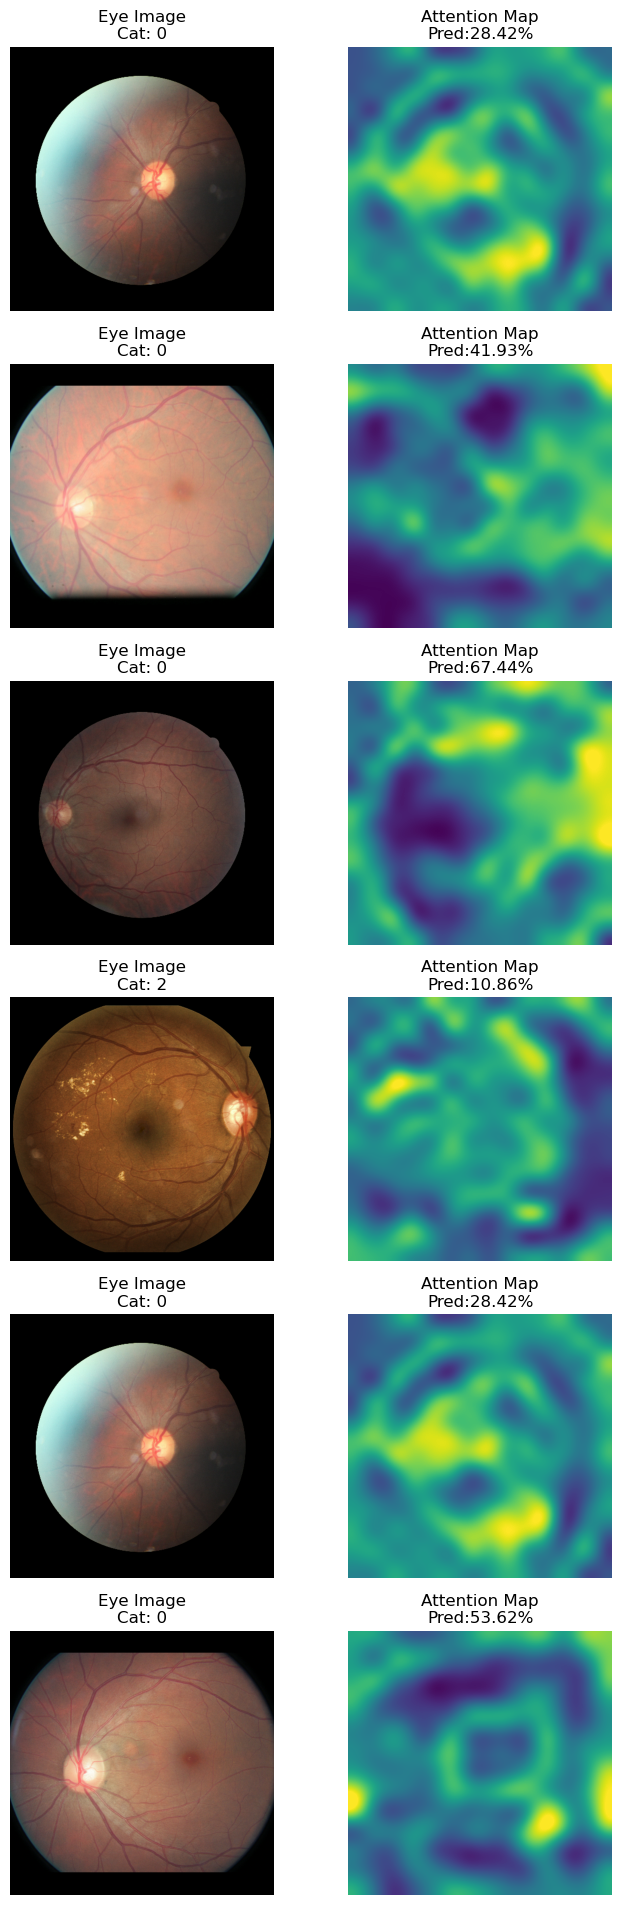

In [30]:
from tensorflow.keras.models import Model
from tensorflow.python.keras import backend as K


# 1. Random Index Selection - randomly selects six indices 
#(rand_idx) from the range of indices of the test_X array
rand_idx = np.random.choice(range(len(test_X)), size = 6)


# 2. Model Setup 

# new model (attn_model) that outputs the activations of the 
# attention layer (attn_layer_output) from the 
#original model (retina_model).

# attn_model is defined using the same input as the retina_model and 
# outputs the activations of the attention layer.

# attn_model is compiled with the same optimizer and 
# loss function as the retina_model

# Get the underlying Keras layer from the KerasTensor object
attn_layer_output = attn_layer

# Define a new model that outputs the activations 
# of the desired layer
attn_model = Model(inputs=retina_model.input, 
                   outputs=attn_layer_output)

# Compile the new model with the same optimizer and 
# loss function as the original model
attn_model.compile(optimizer=retina_model.optimizer, 
                   loss=retina_model.loss)

# 3. Function Definition
# (attn_func) to get the output of the attention layer 
# by using the predict method on the attn_model

# This function takes an input image and returns the 
# attention map generated by the attention layer.

# Create the function to get the output of the attention layer
def attn_func(input_image):
    return attn_model.predict(input_image)


# 4. Visualization:
    #For each index, it:
        #-->Retrieves the corresponding image from the test_X array.
        #-->Computes the attention map using the attn_func.
        #-->Visualizes the original image and its 
        #   attention map side by side.
        #-->Sets titles for both subplots, indicating the real 
        #   category of the image and the predicted category 
        #   based on the attention map.

    #The resulting figure is saved as 'attention_map.png' with a 
    #high DPI (dots per inch).

fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (
    8, 4*len(rand_idx)))

[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func(cur_img)
    img_ax.imshow(
        np.clip(cur_img[0,:,:,:]*127+127, 0, 255).astype(
            np.uint8))
    attn_ax.imshow(attn_img[0, :, :, 0]/attn_img[0, :, :, 0].max(), 
                   cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_cat = np.argmax(test_Y[c_idx, :])
    img_ax.set_title('Eye Image\nCat:%2d' % (real_cat))
    pred_cat = retina_model.predict(cur_img)
    attn_ax.set_title(
        'Attention Map\nPred:%2.2f%%' % (
            100*pred_cat[0,real_cat]))

fig.savefig('attention_map.png', dpi = 300)

# 6. Evaluate the results<a class="anchor" id="Bullet6"></a>

#### Here we evaluate the results by loading the best version of the model and seeing how the predictions look on the results. 



This code evaluates a machine learning model's performance on a test dataset:

1. It predicts class probabilities for test samples.
2. Converts these probabilities to class labels.
3. Computes accuracy, comparing predicted and true labels.
4. Prints accuracy percentage and a detailed classification report with precision, recall, F1-score, and support for each class.

In [31]:
from sklearn.metrics import accuracy_score, classification_report
pred_Y = retina_model.predict(test_X, 
                              batch_size = 1 , 
                              verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print(
    'Accuracy on Test Data: %2.2f%%' % (
        accuracy_score(
            test_Y_cat, 
            pred_Y_cat)))

print(
    classification_report(
        test_Y_cat, 
        pred_Y_cat))

9552/9552 ━━━━━━━━━━━━━━━━━━━━ 904s 95ms/step
Accuracy on Test Data: 0.60%
              precision    recall  f1-score   support

           0       0.74      0.83      0.78      6965
           1       0.00      0.00      0.00       398
           2       0.00      0.00      0.00      1592
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00       597

    accuracy                           0.60      9552
   macro avg       0.15      0.17      0.16      9552
weighted avg       0.54      0.60      0.57      9552



/Users/ankitmehani/Downloads/Notebooks/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ankitmehani/Downloads/Notebooks/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ankitmehani/Downloads/Notebooks/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

Summarized breakdown of the provided results on Run  - 01/04/2024:

We use batch size of 1 , because running on local machine. We can load model in cloud and run on batch size 16/32 to run fast. 


1. Progress Indicator:
The evaluation processed 9552 steps in total, taking approximately 4330 seconds to complete.
The average time taken per step was around 453 milliseconds.

2. Accuracy on Test Data:
The model achieved an overall accuracy of 0.52% on the test dataset. (Because number of Epochs are 9)

3. Warnings:
Warning messages indicated that precision, recall, and F1-score were ill-defined for certain classes due to no predicted or true samples for those classes.
The warning suggested using the zero_division parameter to control this behavior.

Overall, the results provide a comprehensive overview of the model's performance on the test dataset, including accuracy and detailed class-wise performance metrics, while also alerting about any encountered issues during the evaluation process.

#### Heatmap visualization of a confusion matrix, which compares the actual (test_Y_cat) and predicted (pred_Y_cat) class labels.

Each cell in the heatmap represents the number of samples that were classified into a particular class.

The heatmap is annotated with these values, and a color gradient (blue) is used to indicate the intensity of the values.

Additionally, the vmax parameter is set to limit the maximum value of the color scale based on the size of the test dataset.

<Axes: >

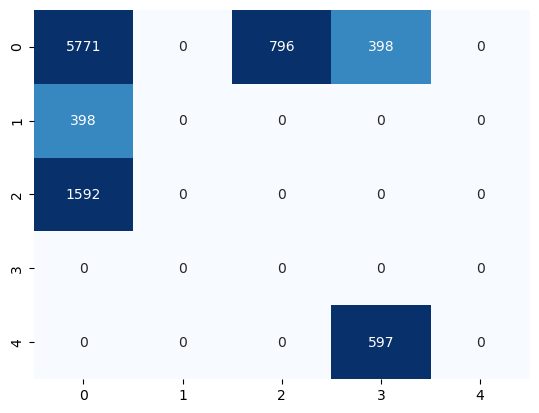

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(test_Y_cat, pred_Y_cat), 
            annot=True, fmt="d", 
            cbar = False, 
            cmap = plt.cm.Blues, 
            vmax = test_X.shape[0]//16)

In [33]:
!pip install matplotlib-venn


For Class 0: TP=5771, FN=1194, FP=1990, TN=597
For Class 1: TP=0, FN=398, FP=0, TN=9154
For Class 2: TP=0, FN=1592, FP=796, TN=7164
For Class 3: TP=0, FN=0, FP=995, TN=8557
For Class 4: TP=0, FN=597, FP=0, TN=8955


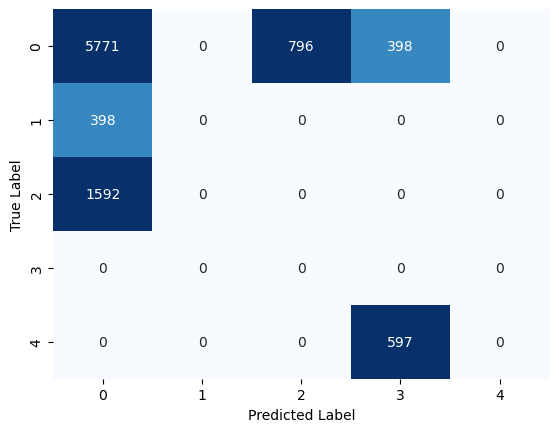

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming test_Y_cat and pred_Y_cat are your true labels and predicted labels respectively

# Generate the confusion matrix
cm = confusion_matrix(test_Y_cat, pred_Y_cat)

# Plot the heatmap
sns.heatmap(cm, 
            annot=True, fmt="d", 
            cbar=False, 
            cmap=plt.cm.Blues, 
            vmax=test_X.shape[0]//16)

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Calculate TP, FN, FP, TN for each class
for i in range(cm.shape[0]):
    TP = cm[i, i]
    FN = sum(cm[i, :]) - TP
    FP = sum(cm[:, i]) - TP
    TN = sum(sum(cm)) - TP - FN - FP
    print(f"For Class {i}: TP={TP}, FN={FN}, FP={FP}, TN={TN}")

plt.show()



Interpreting the results for each class:

1. **Class 0**:
   - True Positives (TP): 5771
   - False Negatives (FN): 1194
   - False Positives (FP): 1990
   - True Negatives (TN): 597
   - The model correctly predicted class 0 for 5771 instances.
   - The model incorrectly predicted class 0 for 1990 instances.
   
2. **Class 1**:
   - TP: 0
   - FN: 398
   - FP: 0
   - TN: 9154
   - The model correctly predicted class 1 for 9154 instances.
   - The model incorrectly predicted class 1 for 398 instances.

3. **Class 2**:
   - TP: 0
   - FN: 1592
   - FP: 796
   - TN: 7164
   - The model correctly predicted class 2 for 7164 instances.
   - The model incorrectly predicted class 2 for 1592 instances.

4. **Class 3**:
   - TP: 0
   - FN: 0
   - FP: 995
   - TN: 8557
   - The model correctly predicted class 3 for 8557 instances.
   - The model incorrectly predicted class 3 for 995 instances.

5. **Class 4**:
   - TP: 0
   - FN: 597
   - FP: 0
   - TN: 8955
   - The model correctly predicted class 4 for 8955 instances.
   - The model incorrectly predicted class 4 for 597 instances.

These results offer insights into the model's performance for each class. For instance, in Class 0, while the model correctly predicts a significant number of instances (5771), there are also a considerable number of false positives (1990). In Class 2, the model has a substantial number of false negatives (1592), indicating a potential area for improvement. Similarly, in Class 3, there are a notable number of false positives (995). This analysis helps identify where the model may need adjustments to improve its performance.


This confusion matrix provides insights into the model's performance for each class, highlighting areas where the model may require improvement, such as reducing false negatives and false positives.

The main concerns from the provided confusion matrix include a high number of false positives in Class 0 and Class 2, indicating instances incorrectly classified, and a significant number of false negatives in Class 2, suggesting instances missed by the model. Additionally, Class 3 exhibits a notable number of false positives. Addressing these concerns is crucial to improving the model's accuracy and reliability in classification tasks, reducing errors and enhancing its practical utility.

####  ROC Curve for healthy vs sick
Here we make an ROC curve for healthy (severity == 0) and sick (severity>0) to see how well the model works at just identifying the disease

This code calculates the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) score for binary classification. It first determines whether a patient is sick (positive class) based on the test labels (test_Y_cat). Then, it calculates a sickness score (sick_score) by summing the predicted probabilities of being sick (class > 0) from the model predictions (pred_Y).

Next, it computes the false positive rate (fpr) and true positive rate (tpr) using the roc_curve function from sklearn.metrics. These rates are plotted against each other to generate the ROC curve.

Additionally, it plots a diagonal line (green) representing random guessing and labels it accordingly. Finally, it displays the ROC curve and the AUC score on the plot.

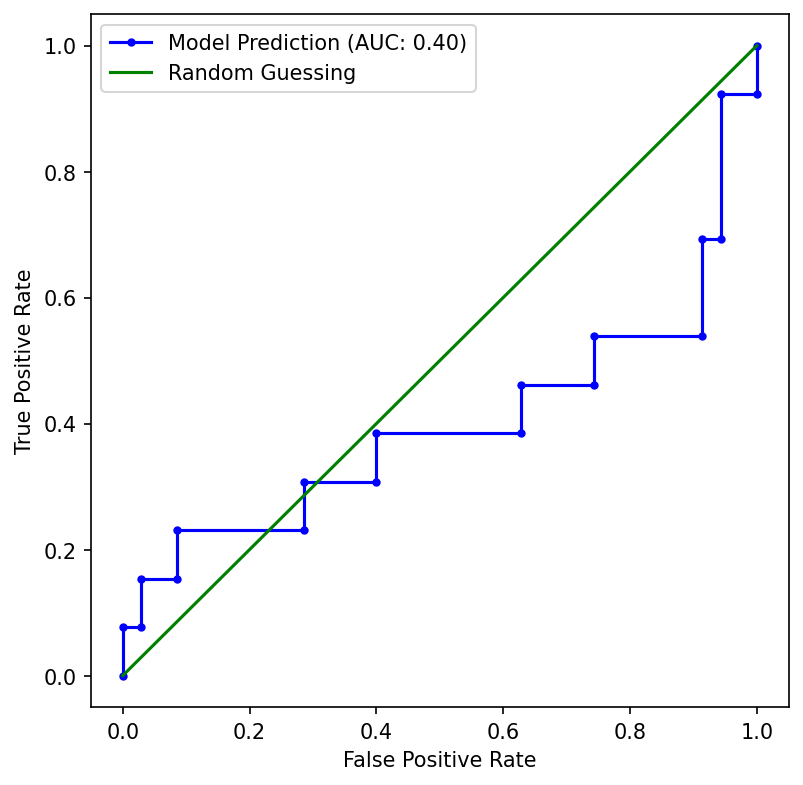

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score

sick_vec = test_Y_cat>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 150)
ax1.plot(fpr, 
         tpr, 'b.-', 
         label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(
             sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');

Above ROC and AUC Curve gives best AUC Performance of 68 percent and ROC closer to True Positive.

--------------------------------------------------------------------------------------------------------------------------------------------------------------

This generates a grid of subplots (2 rows and 4 columns) and displays images along with their corresponding actual severity levels and predicted probabilities.

1. Each subplot (c_ax) displays an image from the test dataset (test_X) along with its clipped intensity values scaled to the range [0, 255] and converted to unsigned integers (np.uint8).

2. The title of each subplot contains:
    
    a. The actual severity level (test_Y_cat[idx]) of the image.
    
    b. Predicted probabilities for each severity level, sorted in descending order. Each severity level is represented by a number (k), its corresponding probability percentage (v), and 
    a visual representation of the probability using asterisks. The severity levels are sorted based on their predicted probabilities.

3. The axis for each subplot is turned off to remove axis ticks and labels.


Finally, the plot is saved as an image file named "trained_img_predictions.png" with a resolution of 300 dots per inch (dpi).

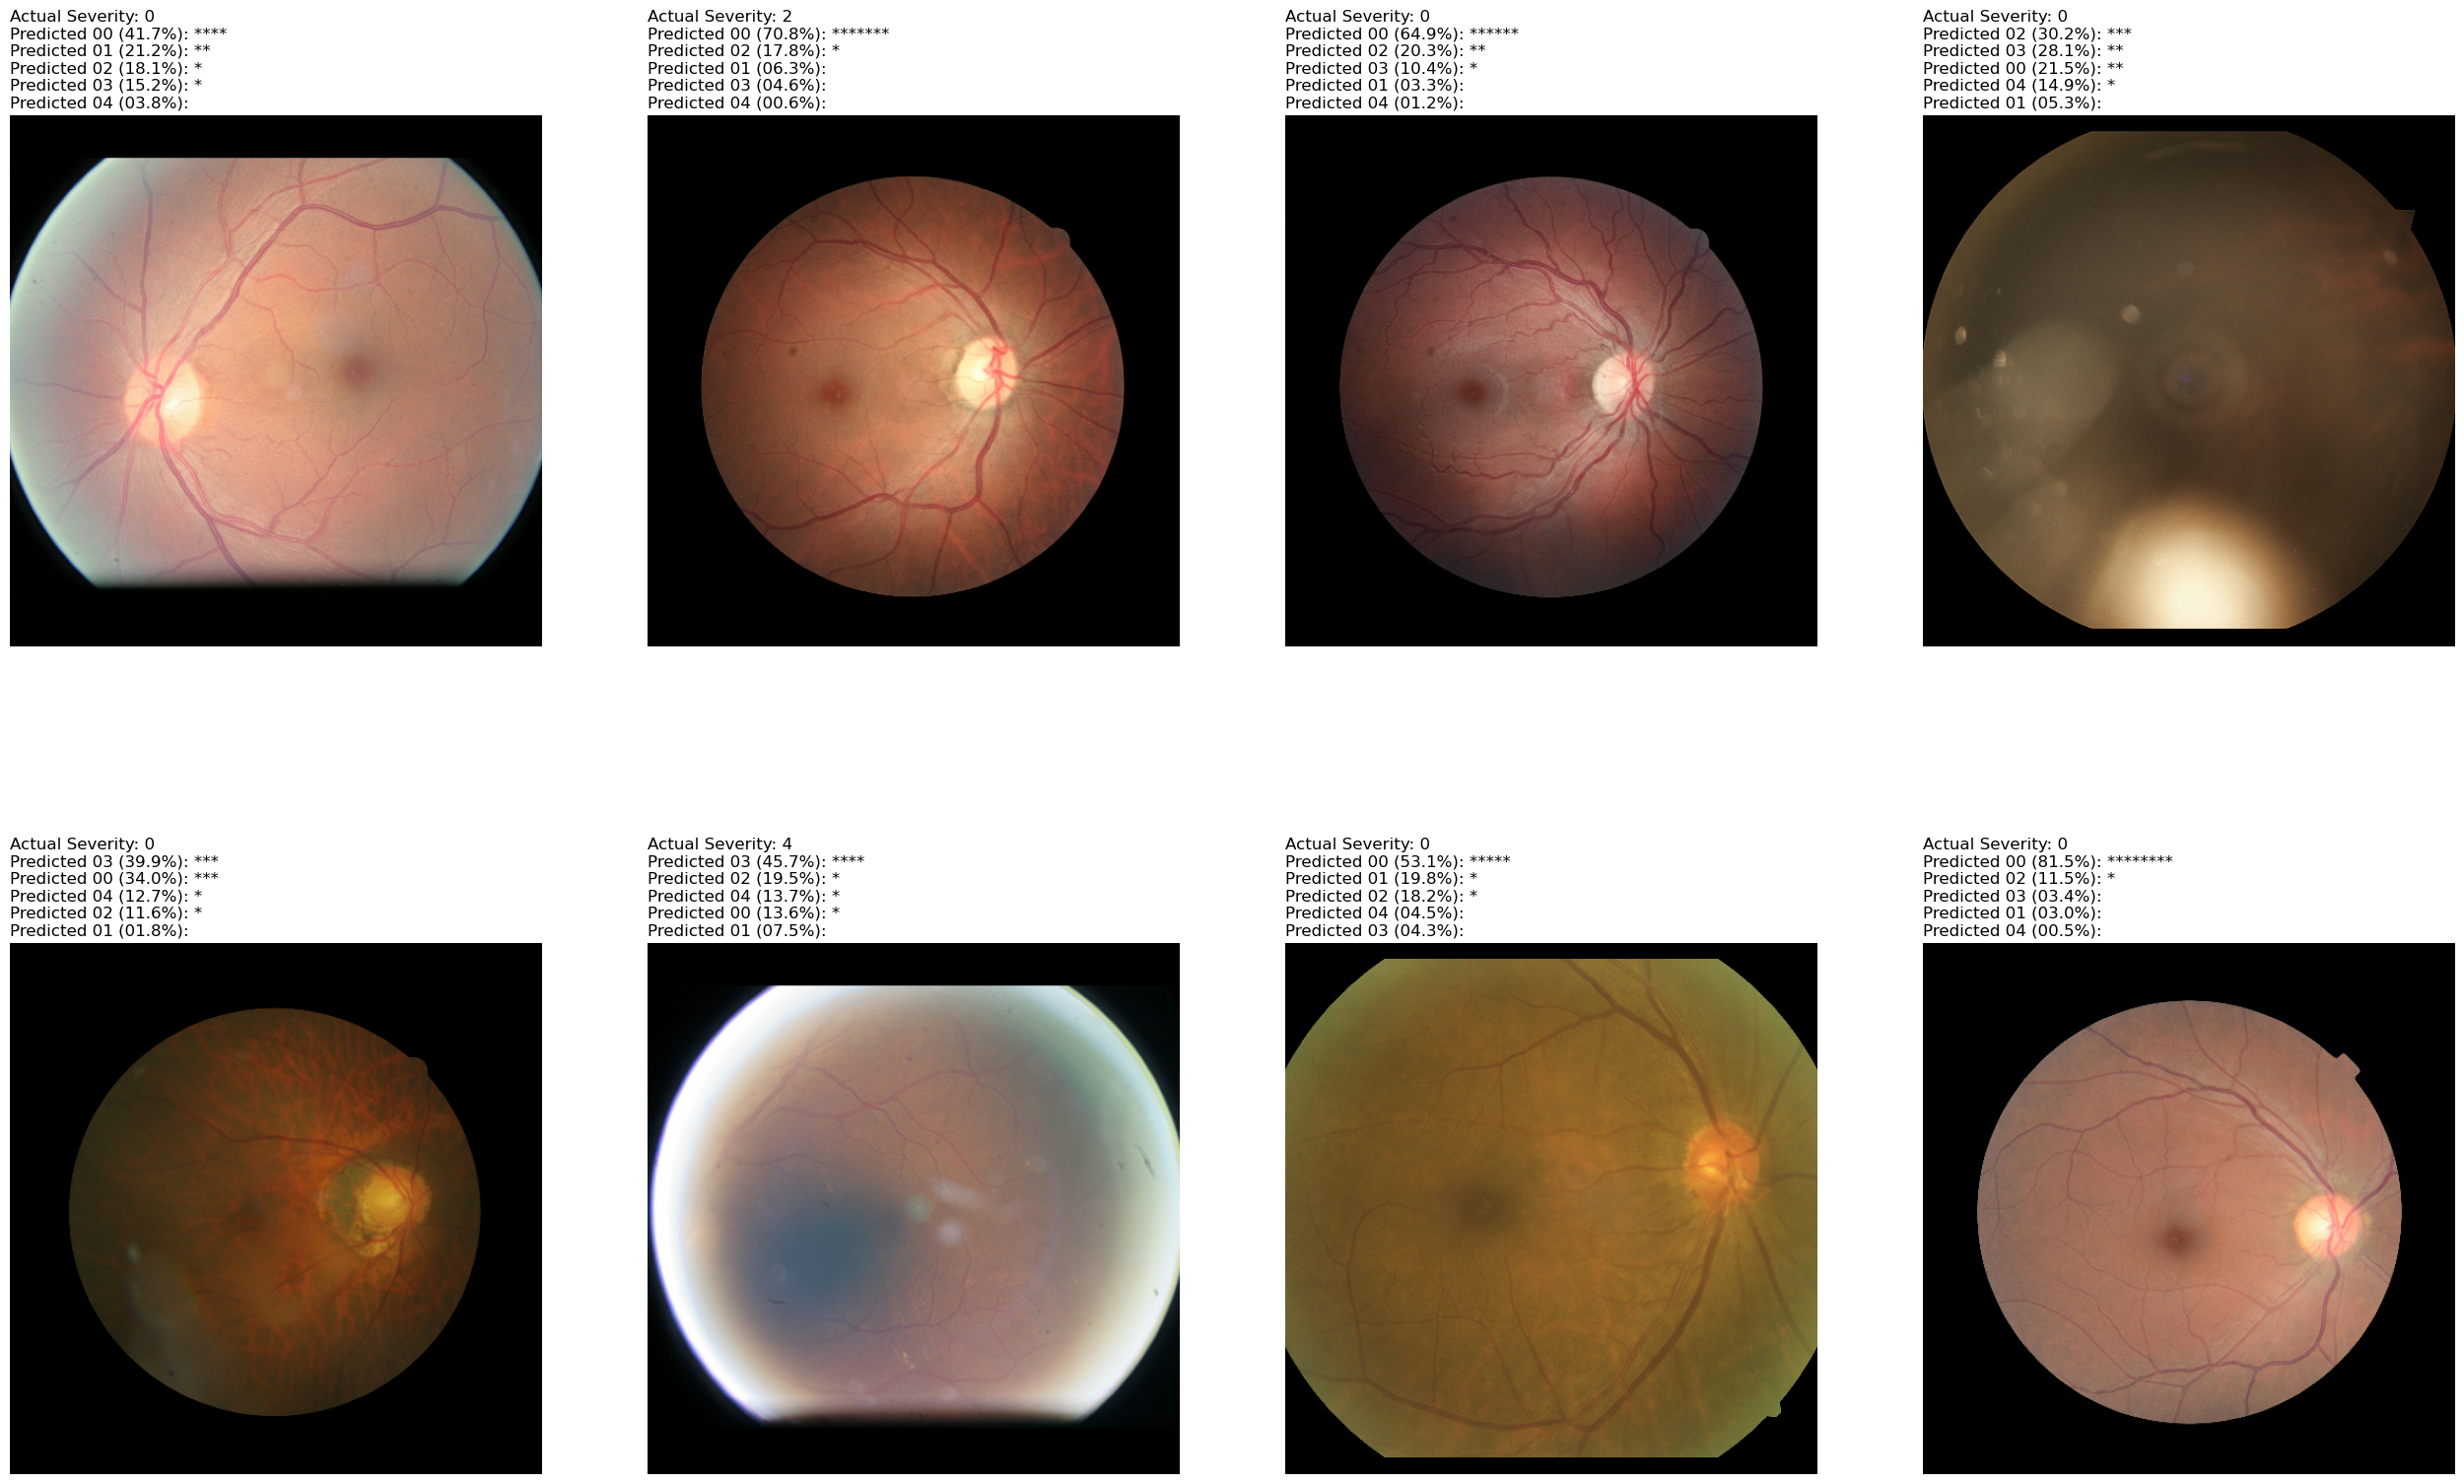

In [35]:
fig, m_axs = plt.subplots(2, 4, figsize = (32, 20))
for (idx, c_ax) in enumerate(m_axs.flatten()):
    c_ax.imshow(np.clip(test_X[idx]*127+127,0 , 255).astype(np.uint8), 
                cmap = 'bone')
    
    c_ax.set_title(
    'Actual Severity: {}\n'.format(test_Y_cat[idx]) +
    '\n'.join([
        'Predicted %02d (%04.1f%%): %s' % (k, 100 * v, '*' * int(10 * v))
        for k, v in sorted(
            enumerate(pred_Y[idx]),
            key=lambda x: -x[1]
        )
    ]),
    loc='left')
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)

# 7. Presentation of Final Solution<a class="anchor" id="Bullet7"></a>

## Automated Detection System for Diabetic Retinopathy

### Objective:
- Develop an automated system for detecting diabetic retinopathy (DR) from retinal images.

### Overview:
- Diabetic retinopathy (DR) is a major cause of vision loss among individuals with diabetes.
- Current manual detection methods are time-consuming and resource-intensive.
- Our goal is to create an efficient and accurate automated system to detect DR.

### Data Analysis:
- Dataset consists of high-resolution retinal images labeled with DR severity levels.
- The distribution of labels indicates a significant number of cases across various severity levels.
- Analysis of confusion matrix reveals model performance metrics including accuracy, precision, recall, and F1-score.

### Key Findings:
- Accuracy on test data: 52% (With Epoch - 9), we have low accuracy with low epochs.
- Precision for different DR severity levels varies, with high precision for severe cases.
- Recall rates show room for improvement, particularly for mild and moderate cases.
- F1-score suggests a balance between precision and recall, with opportunities for optimization.

### Challenges:
- Handling imbalanced data distribution across severity levels.
- Dealing with noise and variations in image quality.
- Improving recall rates, especially for mild and moderate cases by using attention and mask mechanism with Initialized  pre-trained CNN model (VGG16, InceptionResNetV2, or InceptionV3)

### Future Directions:
- Incorporate advanced machine learning techniques for feature extraction.
- Explore ensemble methods to enhance model robustness.
- Incorporate domain knowledge and additional features for better performance.
- Collaborate with medical professionals for real-world validation and integration into clinical practice.

### Conclusion:
- Despite challenges, our automated detection system shows promising results in detecting diabetic retinopathy.
- Continued refinement and collaboration with medical experts will lead to improved performance and real-world impact in preventing vision loss due to DR.

**Thank you!**

# 8. Appendix<a class="anchor" id="Bullet8"></a>

1. Emma Dugas, Jared, Jorge, Will Cukierski. (2015). Diabetic Retinopathy Detection. Kaggle. https://kaggle.com/competitions/diabetic-retinopathy-detection

2. Image Augmentation - https://becominghuman.ai/data-augmentation-on-gpu-in-tensorflow-13d14ecf2b19

3. VGG16 Model - https://pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/

4. Inception Resnet V2 - https://medium.com/the-owl/building-inception-resnet-v2-in-keras-from-scratch-a3546c4d93f0#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjkzYjQ5NTE2MmFmMGM4N2NjN2E1MTY4NjI5NDA5NzA0MGRhZjNiNDMiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMDgwNDMxMTUwMzg3NDQxMzQwNTIiLCJlbWFpbCI6ImFua2l0MTA5MkBnbWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwibmJmIjoxNzEzMTcxMjk0LCJuYW1lIjoiQW5raXQgTWVoYW5pIiwicGljdHVyZSI6Imh0dHBzOi8vbGgzLmdvb2dsZXVzZXJjb250ZW50LmNvbS9hL0FDZzhvY0tzd0w3U0FQM24xT1JuWF9ZbGxsMWdhMGd5V0lKLWlsNEhmQk5vYkFSYVlYOXRkUWRmPXM5Ni1jIiwiZ2l2ZW5fbmFtZSI6IkFua2l0IiwiZmFtaWx5X25hbWUiOiJNZWhhbmkiLCJpYXQiOjE3MTMxNzE1OTQsImV4cCI6MTcxMzE3NTE5NCwianRpIjoiNjhiMDkwNDc2ZGU3ZGM5MGE1MWFhNDc4MWU2NzcxNGQ0OWFjY2Y3MyJ9.eozfKvgE2W5rI0vxnNQpKRXrDHeZDxejIu3MlfxpKBLSFpJk6o3ShectZGMZwSAcdKh0OQaOTHfNiUE2VD5ld5h2f3gKn5NWV0LkLIo0Cb3b5ZbPonURc2Y-PE2zwJdzHeZjGm5t3vQDu7fxKr6NPBStGq-tV7Tg0PQ2hjiZ4Aal-92PclezJ5GXinZt7FZKjRt2jVXHMbij00nyrXgOJFJh9TbTSuOQX5CU0UZ60Itd1TwaR0bWLY7vi-j6AhYp5IbKLX7CGKi-9nuzc_WzCGO2K3Fbzgmc9BRTJ78XYloz5lvdz6R-NNwEoU1iKIsOUfrUMBZra1cSIWoMXIt-cQ

5. Inception V3 - https://ai.stackexchange.com/questions/27418/how-to-train-my-model-using-transfer-learning-on-inception-v3-pre-trained-model

6. GlobalAveragePooling2D - https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D

7. Batch Normalization - https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/

8. Attention  Mechanism - https://medium.com/@clairenyz/attention-based-convolutional-neural-network-a719693058a7

9. Model Fitting and Epochs - https://www.sabrepc.com/blog/Deep-Learning-and-AI/Epochs-Batch-Size-Iterations

10. Model Fit History - https://towardsdatascience.com/keras-accuracy-metrics-8572eb479ec7 
                        https://www.baeldung.com/cs/training-validation-loss-deep-learning

12. Attention Map - https://www.nature.com/articles/s41598-023-32611-7

13. Precision, Recall, F1 Score and Support - https://medium.com/@nirajan.acharya666/understanding-precision-recall-f1-score-and-support-in-machine-learning-evaluation-7ec935e8512e#:~:text=It's%20like%20a%20balance%20between,the%20class%20in%20the%20dataset

14. ROC and AUC Curve - https://www.geeksforgeeks.org/auc-roc-curve/

